In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import sqlite3
import re
from scipy import stats

# plot config 

sns.set_style('ticks')
SMALL = 14
MEDIUM = 16
LARGE = 18

# fonts
plt.rc('font', size=SMALL)          # controls default text sizes
plt.rc('axes', titlesize=LARGE, labelsize=MEDIUM)  # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

# axes/tick width
plt.rc('axes', linewidth=2) 
plt.rc('xtick.major', size=10, width=2)
plt.rc('ytick.major', size=10, width=2)
plt.rc('axes.spines', right=False, top=False)

# linewidth
plt.rc('lines', linewidth=2.5, markersize=14)
plt.rc('markers', fillstyle='none')

# see https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
# consider rcparams to override defaults? 

# setting colors
pal = sns.color_palette()
sns.palplot(pal)
blue = sns.color_palette()[0]
orange = sns.color_palette()[1]
red = sns.color_palette()[3]
grey = sns.color_palette()[7]
colors = [blue, orange, red, grey]

a='#1b9e77'
b='#ff7824'
c='#7570b3'
col = sns.color_palette([a,b,c])
sns.palplot(col)
a,b,c= col

# London Marathon EDA
### Author: Elliot Quan

#### Description: This notebook loads the data from all runners with complete split profiles (dropped ~6k/240k)

In [2]:
# helper fxns

def df_selector(df, level, keywords):
    """Utility fxn to select the level and columns to search for a multiindex df.
    keywords must be a list of column names. If the list is length >1, it will perform exact matching.
    """
    if len(keywords) > 1:
        return df.loc[:, df.columns.get_level_values(level).isin(keywords)]
    return df.loc[:, df.columns.get_level_values(level).str.contains(keywords[0])]


def split_format(df, names = None, multi=False):
    """Convert all time columns in df from seconds to timedelta (HH:MM:SS)
    multi denotes MultiIndex columns, which will select split first -> mean second
    
    If multi is False, names will expect a list of column names containing split data
    """
    if multi:
        temp = df_selector(df, 0, ['split'])
        temp = df_selector(temp, 1, ['mean'])
        return temp.apply(lambda x: pd.to_timedelta(x, unit='seconds', errors='coerce').dt.round('s'))
    else:
        if names:
            return df.loc[:, names].apply(lambda x: pd.to_timedelta(x, unit='seconds', errors='coerce').dt.round('s'))
        temp = df_selector(df, 0, ['split'])
        return temp.apply(lambda x: pd.to_timedelta(x, unit='seconds', errors='coerce').dt.round('s'))
def CoV(x):
    """Coefficient of Variation = sd/mean*100 """
    return np.round(np.std(x)/np.mean(x)*100,1)



# Update: read data from complete table



In [3]:
# original code to generate cov. 


# # if reading from database, this code should be commented out
# diffs = diffs/60/3.1
# # this takes a few seconds to run...
# cov = diffs.apply(lambda x: np.std(x)/np.mean(x)*100, axis=1)
# df['cov'] = cov
# df = df.dropna(subset=['cov'])



# # if writing to database, this code should be commented out

con = sqlite3.connect('../nonelite.db')

sql = """
SELECT * FROM complete2;
"""
df = pd.read_sql_query(sql, con)
con.close()

# the df below excludes roughly 5k runners with missing split data. 

In [4]:
df.shape

(228495, 44)

In [5]:
elt = df.groupby(['elite'])['cov', 'split_Finish'].median()
elt['split_Finish'] = elt['split_Finish']/60
elt['cov'][1]

7.934709236572559

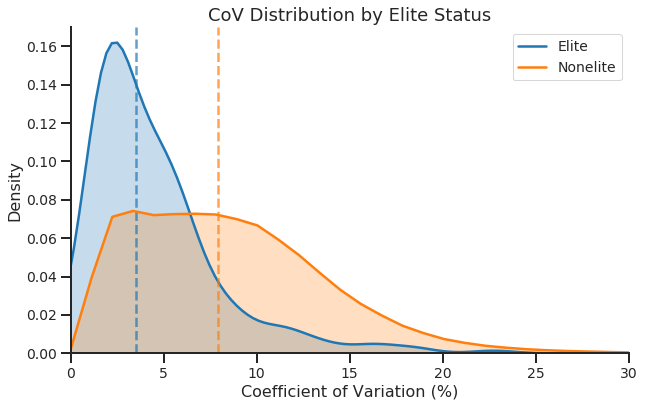

In [6]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['elite'] == 'elite']['cov'], label='Elite', shade=True, color=blue)
plt.axvline(elt['cov'][0], color=blue, linestyle='dashed', alpha=.7)
sns.kdeplot(df[df['elite'] == 'nonelite']['cov'], label='Nonelite', shade=True, color=orange)
plt.axvline(elt['cov'][1], color=orange, linestyle='dashed', alpha=.7)

plt.xlabel('Coefficient of Variation (%)')
plt.xlim((0,30))
plt.ylabel('Density')
plt.title('CoV Distribution by Elite Status')  
plt.savefig('img/cov/cov_distr_elite.png')
plt.show()


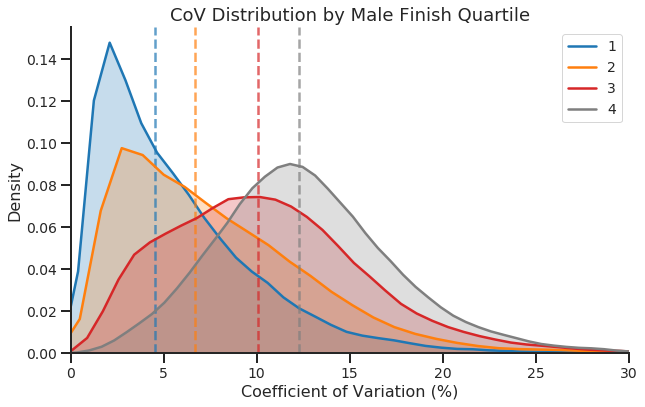

In [7]:
# distribution of CoV based on runner finish quartile

quart = df[df['gender']=='M'].groupby(['quartile'])['cov', 'split_Finish'].median()


plt.figure(figsize=(10,6))
for q in [1,2,3,4]:
    sns.kdeplot(df[(df['quartile'] == q) & (df['gender']=='M')]['cov'], label=q, shade=True, color=colors[q-1])
    plt.axvline(quart['cov'][q], color=colors[q-1], linestyle='dashed', alpha=.7)
plt.xlabel('Coefficient of Variation (%)')



plt.xlim((0,30))
plt.ylabel('Density')
plt.title('CoV Distribution by Male Finish Quartile')   
plt.savefig('img/cov/cov_distr_quartile_M.png')
plt.show()

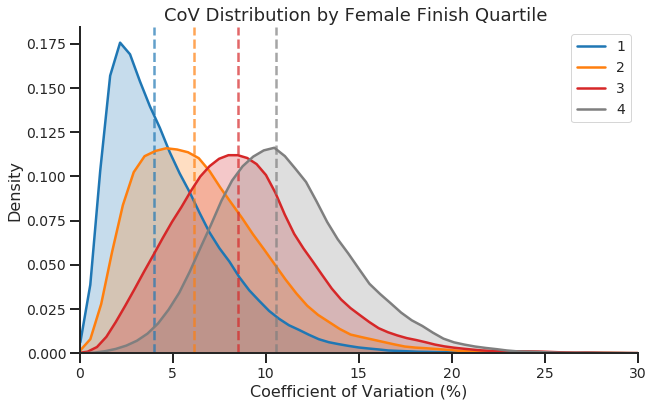

In [8]:
# distribution of CoV based on runner finish quartile
quart2 = df[df['gender']=='F'].groupby(['quartile'])['cov', 'split_Finish'].median()
plt.figure(figsize=(10,6))
for q in [1,2,3,4]:
    sns.kdeplot(df[(df['quartile'] == q) & (df['gender'] == 'F')]['cov'], label=q, shade=True, color=colors[q-1])
    plt.axvline(quart2['cov'][q], color=colors[q-1], linestyle='dashed', alpha=.7)
plt.xlabel('Coefficient of Variation (%)')



plt.xlim((0,30))
plt.ylabel('Density')
plt.title('CoV Distribution by Female Finish Quartile ')   
plt.savefig('img/cov/cov_distr_quartile_F.png')
plt.show()

In [9]:
rep = df.groupby(['repeat'])['cov'].median()
rep[0]

7.749489561985616

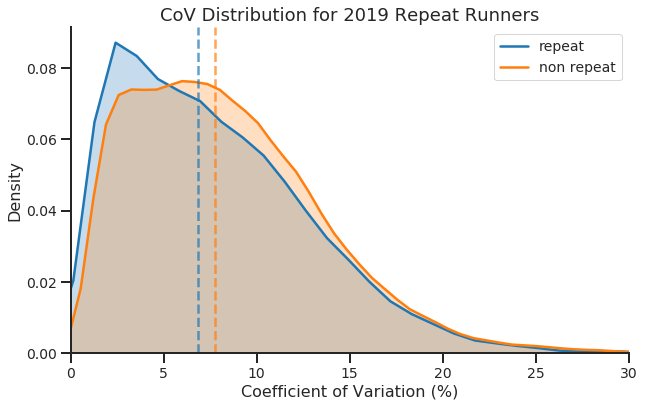

In [10]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['repeat'] == True]['cov'], label='repeat', shade=True)
plt.axvline(rep[0], color=orange, linestyle='dashed', alpha=.7)
sns.kdeplot(df[df['repeat'] == False]['cov'], label='non repeat', shade=True)
plt.axvline(rep[1], color=blue, linestyle='dashed', alpha=.7)



plt.xlabel('Coefficient of Variation (%)')
plt.xlim((0,30))
plt.ylabel('Density')
plt.title('CoV Distribution for 2019 Repeat Runners')  
plt.savefig('img/cov/cov_distr_repeat.png')
plt.show()



In [11]:
gend = df.groupby(['gender'])['cov'].median()
gend

gender
F    7.301975
M    8.485626
Name: cov, dtype: float64

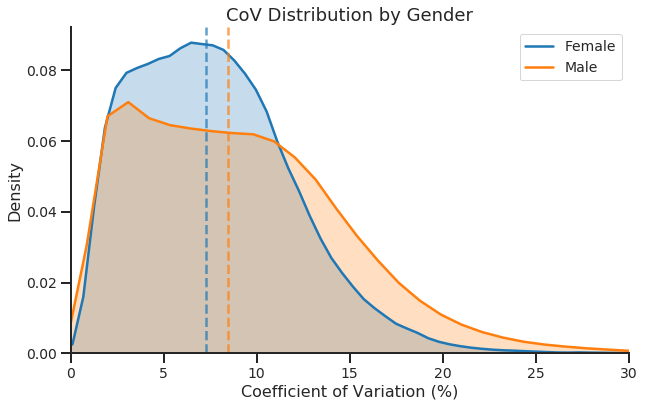

In [12]:
# distribution of CoV based on runner finish quartile
plt.figure(figsize=(10,6))

sns.kdeplot(df[df['gender'] == 'F']['cov'], label='Female', shade=True, color=blue)
sns.kdeplot(df[df['gender'] == 'M']['cov'], label='Male', shade=True, color=orange)


plt.axvline(gend[0], color=blue, linestyle='dashed', alpha=.7)
plt.axvline(gend[1], color=orange, linestyle='dashed', alpha=.7)

plt.xlabel('Coefficient of Variation (%)')
plt.xlim((0,30))
plt.ylabel('Density')
plt.title('CoV Distribution by Gender')   
plt.savefig('img/cov/cov_distr_gender.png')
plt.show()

In [13]:
# women tend to have a smaller CoV 
# note that we divide by mean finish time, which on average is higher for women (thus CoV ends up being smaller)
# however this behavior is justified, since if a faster and slower runner had the same stdev, the faster
# runner would have a higher variation in pace

med = df['cov'].median()

print(f'median cov {med}')
df['consistent'] = df['cov'] < med

top25 = df['cov'].quantile(.25)
df['consistent_top25'] = df['cov'] < top25

median cov 7.929018929980025


In [14]:
# can see that consistent split runners average faster times - roughly 50 minutes faster!

df.groupby(['elite', 'gender', 'consistent'])['split_Finish'].mean()

# stratify by finish group (probably just do top 25, top 50, top 75, top 100 in M/F separately)


elite     gender  consistent
elite     F       False          9091.166667
                  True           8901.990291
          M       False          8487.160000
                  True           7923.753968
nonelite  F       False         19270.562741
                  True          15961.883288
          M       False         16837.863338
                  True          13690.109991
Name: split_Finish, dtype: float64

In [15]:
df.groupby(['gender'])['split_Finish', 'cov'].median()

,split_Finish,cov
gender,,
F,17210.0,7.301975
M,15093.0,8.485626


In [16]:
cat = df.groupby(['gender', 'category'])['split_Finish', 'cov'].mean()
#cat['split_Finish'] = split_format(cat, names=['split_Finish'], multi=False)
# convert to minutes
cat['split_Finish'] = cat['split_Finish']/60
cat.reset_index(inplace=True)
cat

,gender,category,split_Finish,cov
0,F,18-39,290.754072,7.938294
1,F,40-44,285.816229,7.229532
2,F,45-49,287.978681,7.333309
3,F,50-54,292.136126,7.616554
4,F,55-59,300.427383,7.890839
5,F,60-64,302.642850,7.790567
6,F,65-69,316.682642,8.005463
7,F,70+,335.485836,8.419977
8,M,18-39,255.325074,9.580358
9,M,40-44,249.684925,8.558817


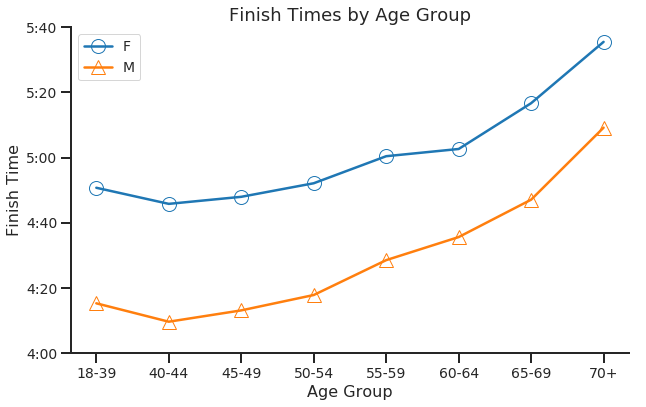

In [17]:
# note: catplot returns a facetgrid object, which needs to be manipulated in the following way (different from plt)
# ax = sns.catplot(data=cat, x="category", y="split_Finish", hue='gender', 
#             linestyles=["-", "-"], kind="point", 
#             hue_order = ['F', 'M'],legend_out=False)
# ax.set(yticks=np.arange(240, 360, 20))
# ax.set(yticklabels=['4:00', '4:20', '4:40', '5:00', '5:20', '5:40'])
# ax.fig.set_size_inches(10,6)

# ax.set(xlabel='Age Group', ylabel='Finish Time', title='Finish Times by Age Group')
# ax.fig.savefig('img/finish_by_age.png')

df1=cat[cat['gender']=='F']
df2=cat[cat['gender']=='M']
plt.figure(figsize=(10,6))
plt.plot('category', 'split_Finish', marker='o', color='C0', label='F', data=df1)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M', data=df2)

plt.legend()
plt.yticks(np.arange(240, 360, 20),
           labels=['4:00', '4:20', '4:40', '5:00', '5:20', '5:40'])
plt.ylabel('Finish Time')
plt.xlabel('Age Group')
plt.title('Finish Times by Age Group')
plt.savefig('img/desc/finish_times_by_age_group.png')
plt.show()


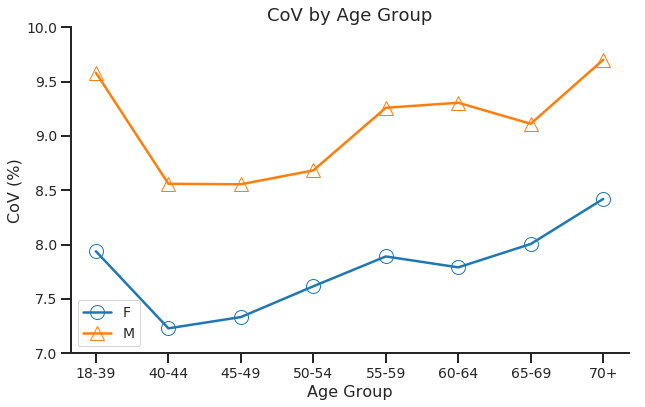

In [18]:
# ax = sns.catplot(data=cat, x="category", y="cov", hue='gender', 
#             linestyles=["-", "-"], kind="point", 
#             hue_order = ['F', 'M'], legend_out=False)

# ax.set(xlabel='Age Group', ylabel='CoV (%)', title='Consistency by Age Group')
# ax.fig.set_size_inches(10,6)
# ax.fig.savefig('img/cov_by_age.png')

# question: are females statistically more consistent?

plt.figure(figsize=(10,6))
plt.plot('category', 'cov', marker='o', color='C0', label='F', 
            data=df1)
plt.plot('category', 'cov', marker='^', color='C1', label='M',
            data=df2)

plt.legend()
plt.yticks(np.arange(7, 10.5, .5))
plt.ylabel('CoV (%)')
plt.xlabel('Age Group')
plt.title('CoV by Age Group')
plt.savefig('img/cov/cov_by_age_group.png')
plt.show()


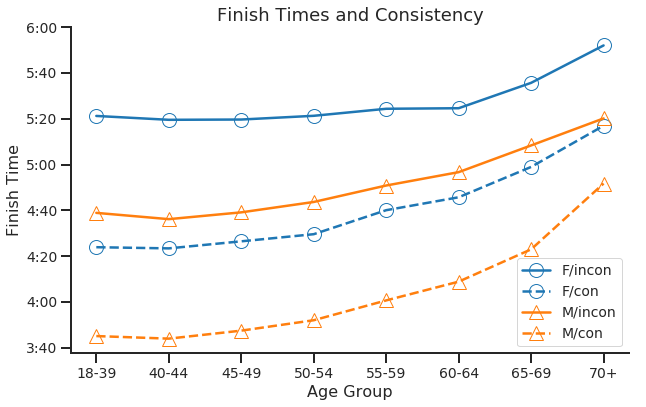

In [19]:
# same plot but with standard matplotlib 

temp = df.groupby(['gender', 'category', 'consistent'])['split_Finish'].mean()/60
temp = temp.reset_index()

df1 = temp[(temp['gender'] == 'F')& (temp['consistent'] == False)]
df2 = temp[(temp['gender'] == 'F')& (temp['consistent'] == True)]
df3 = temp[(temp['gender'] == 'M')& (temp['consistent'] == False)]
df4 = temp[(temp['gender'] == 'M')& (temp['consistent'] == True)]

plt.figure(figsize=(10,6))

plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/incon', 
            data=df1)
plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/con', 
         linestyle='dashed', data=df2)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/incon', 
         data=df3)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/con', 
         linestyle='dashed', data=df4)

plt.legend()

plt.yticks(np.arange(220, 380, 20),labels=['3:40', '4:00', '4:20', '4:40', '5:00', '5:20', '5:40', '6:00'])
plt.ylabel('Finish Time')
plt.xlabel('Age Group')
plt.title('Finish Times and Consistency')

plt.savefig('img/cov/finish_by_age_cov.png')
plt.show()

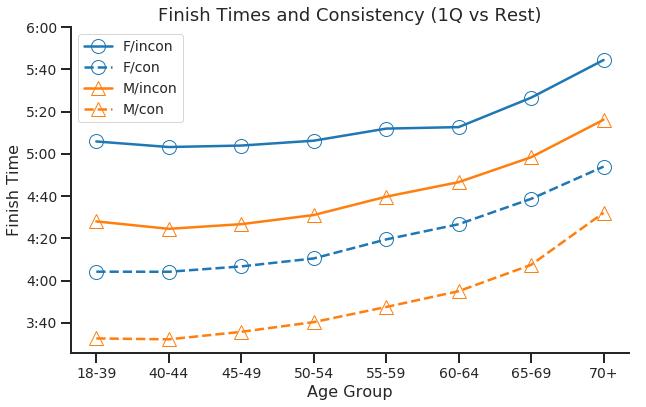

In [20]:
# same plot but with standard matplotlib 

temp = df.groupby(['gender', 'category', 'consistent_top25'])['split_Finish'].mean()/60
temp = temp.reset_index()

df1 = temp[(temp['gender'] == 'F')& (temp['consistent_top25'] == False)]
df2 = temp[(temp['gender'] == 'F')& (temp['consistent_top25'] == True)]
df3 = temp[(temp['gender'] == 'M')& (temp['consistent_top25'] == False)]
df4 = temp[(temp['gender'] == 'M')& (temp['consistent_top25'] == True)]

plt.figure(figsize=(10,6))

plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/incon', 
            data=df1)
plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/con', 
         linestyle='dashed', data=df2)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/incon', 
         data=df3)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/con', 
         linestyle='dashed', data=df4)

plt.legend()

plt.yticks(np.arange(220, 380, 20),labels=['3:40', '4:00', '4:20', '4:40', '5:00', '5:20', '5:40', '6:00'])
plt.ylabel('Finish Time')
plt.xlabel('Age Group')
plt.title('Finish Times and Consistency (1Q vs Rest)')

plt.savefig('img/cov/finish_by_age_cov25.png')
plt.show()

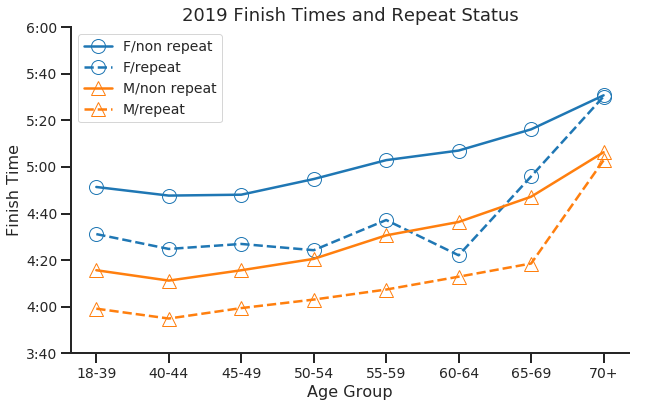

In [21]:
temp = df[df['year']==2019].groupby(['gender', 'category', 'repeat'])['split_Finish'].mean()/60
temp = temp.reset_index()
# same plot but with standard matplotlib 
plt.figure(figsize=(10,6))
df1 = temp[(temp['gender']=='F') & (temp['repeat']==False)] 
df2 = temp[(temp['gender']=='F') & (temp['repeat']==True)] 
df3 = temp[(temp['gender']=='M') & (temp['repeat']==False)] 
df4 = temp[(temp['gender']=='M') & (temp['repeat']==True)] 

plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/non repeat', 
            data=df1)
plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/repeat', 
         linestyle='dashed', data=df2)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/non repeat', 
         data=df3)
plt.plot('category', 'split_Finish', marker='^', color='C1', label='M/repeat', 
         linestyle='dashed', data=df4)

plt.legend()

plt.yticks(np.arange(220, 380, 20),labels=['3:40', '4:00', '4:20', '4:40', '5:00', '5:20', '5:40', '6:00'])
plt.ylabel('Finish Time')
plt.xlabel('Age Group')
plt.title('2019 Finish Times and Repeat Status')

plt.savefig('img/desc/finish_by_age_repeat.png')
plt.show()

In [22]:
temp = df[df['year']==2019].groupby(['gender','repeat'])['split_Finish'].mean()/60
temp

gender  repeat
F       0.0       291.772756
        1.0       270.011953
M       0.0       257.837433
        1.0       240.565562
Name: split_Finish, dtype: float64

In [23]:
df[(df['gender']=='F') & (df['repeat']==True) & (df['category']=='55-59')]['split_Finish'].mean()

16632.439655172413

In [24]:
df[(df['gender']=='F') & (df['repeat']==True) & (df['category']=='60-64')]['split_Finish'].mean()

15723.471698113208

In [25]:
df[(df['gender']=='F') & (df['repeat']==True) & (df['category']=='65-69')]['split_Finish'].mean()

17755.914285714287

In [26]:
df.groupby(['category'])['category'].count()/df.shape[0]

category
18-39    0.524515
40-44    0.172209
45-49    0.135902
50-54    0.089901
55-59    0.042193
60-64    0.020736
65-69    0.008932
70+      0.005418
Name: category, dtype: float64

# Negative Split Analysis

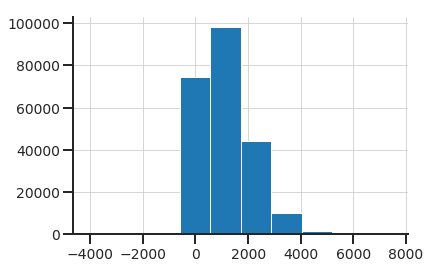

In [27]:
# common wisdom says negative splits are best
# omit 2018 data due to extreme heat

df['split_delta'] = (df['split_Half2']-df['split_Half'])
df['split_perc'] = df['split_delta']/df['split_Finish']*100
df['split_delta'].hist()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


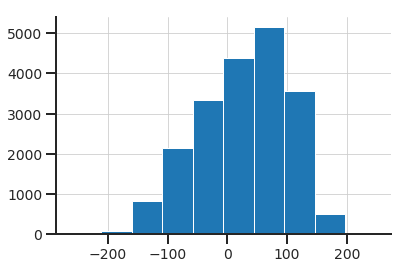

In [28]:
# categorizing runners as neg, even, pos based on split_perc
df['split_type'] = 'positive'
df.loc[df['split_perc'] <= -1, 'split_type'] = 'negative'

cond = (df['split_perc'] < 1) & (df['split_perc'] > -1)
df.loc[cond, 'split_type'] = 'even'


even = df[cond]
even['half/half2p'] = 1 - (df['split_Half']/df['split_Half2'])
even['split_delta'].hist()



# separate into 2 frames, one excluding 2018 since hot weather

splits = df.loc[df['year'] != 2018, ['name', 'year', 'gender', 'elite', 'category', 'quartile', 
                   'place_gender', 'place_category', 'cov', 'split_Half', 'split_Half2', 
                   'split_Finish', 'split_delta', 'split_perc', 'split_type', 'repeat']]


n = splits.shape[0]

In [29]:
# TODO: add finish times, add chart to rmd
# maybe change to quantiles instead of randomly picked runners? idk

even_splits = df[df['split_type']=='even']
finish = even_splits['split_Finish']
diff = df_selector(even_splits, 0, ['diff'])
diff.columns = diff.columns.get_level_values(0)
diff = diff.loc[:, ~diff.columns.str.contains('Half')]
ex_even = split_format(diff)
ex_even['finish'] = finish
ex_even['finish'] = split_format(ex_even, names=['finish'])
#ex_even[ex_even['gender']=='M'].iloc[[0, 800, 2000, 5000, 10000]]
ex_even.shape[0]

20068

In [30]:
indices = np.quantile(np.arange(0,ex_even.shape[0]), [.01, .05, .1, .25, .50, .75], interpolation='lower')
ex_even.iloc[indices,:]

,split_5K_diff,split_10K_diff,split_15K_diff,split_20K_diff,split_25K_diff,split_30K_diff,split_35K_diff,split_40K_diff,split_Finish_diff,finish
636,00:17:32,00:17:46,00:17:52,00:18:13,00:17:58,00:17:56,00:18:04,00:18:10,00:07:50,02:31:17
3283,00:19:51,00:19:39,00:19:49,00:19:34,00:19:22,00:19:23,00:19:26,00:19:42,00:08:38,02:45:20
7011,00:20:48,00:20:36,00:20:57,00:20:44,00:20:35,00:20:21,00:20:18,00:20:51,00:09:59,02:55:04
20966,00:23:49,00:22:42,00:22:36,00:22:50,00:22:56,00:23:02,00:23:21,00:23:37,00:10:07,03:14:54
51200,00:25:53,00:26:50,00:26:09,00:26:16,00:26:13,00:26:39,00:26:55,00:27:00,00:11:41,03:43:32
87293,00:27:33,00:29:29,00:29:10,00:29:46,00:30:40,00:28:00,00:28:54,00:29:51,00:13:54,04:07:13


In [31]:


# what percent of runners ran a true negative split? 
n_neg = splits[splits['split_delta']<=0].shape[0]
n_pos = splits[splits['split_delta']>0].shape[0]
perc_neg = n_neg/n_pos*100
print(perc_neg) 

6.054963795465347


In [32]:
# uncomment to make contour plot, takes >2 min

# splits['split_Half_min'] = splits['split_Half']/60
# splits['split_Half2_min'] = splits['split_Half2']/60

# plt.figure(figsize=(10,6))
# sns.kdeplot(splits['split_Half_min'], splits['split_Half2_min'],cmap="Reds", shade=True, bw=.15, shade_lowest=False,  legend=True)
# x = np.linspace(0,250,250)
# plt.plot(x, x, color='C0')
# plt.xlim((60,250))
# plt.ylim((60,250))
# plt.xticks(np.arange(60, 250, 30))
# plt.yticks(np.arange(60, 250, 30))
# plt.annotate('Negative', (175, 125), fontsize=14)
# plt.annotate('Positive', (75, 180), fontsize=14)
# plt.xlabel('Half1 Split (min)')
# plt.ylabel('Half2 Split (min)')
# plt.title('Half1 Split vs Half2 Split')
# plt.savefig('img/split/negsplit_contour.png')

In [33]:
splits.groupby(['elite', 'split_type'])['split_type'].count() / splits.groupby(['elite'])['name'].count()

elite     split_type
elite     even          0.240175
          negative      0.030568
          positive      0.729258
nonelite  even          0.101349
          negative      0.021220
          positive      0.877431
dtype: float64

In [34]:
splitnum = splits.groupby(['split_type'])['split_type'].count()/n*100
splitnum = np.round(splitnum).astype('int64')
splitnum

split_type
even        10
negative     2
positive    88
Name: split_type, dtype: int64

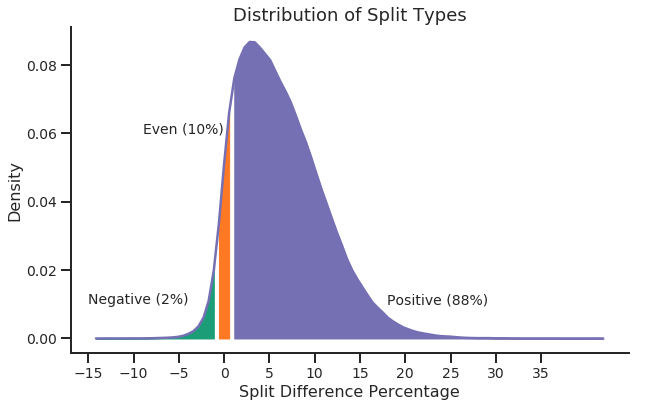

In [35]:
plt.figure(figsize=(10,6))

points = sns.kdeplot(splits['split_perc'], legend=False, color=c).get_lines()[0].get_data()

x = points[0]
y = points[1]

plt.fill_between(x,y, where = x <= -1, color=a)
plt.fill_between(x,y, where = (x<=1) & (x>=-1), color=b)
plt.fill_between(x,y, where = x >= 1, color=c)
plt.xticks([-15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35])


plt.annotate(f'Even ({splitnum[0]}%)', (-9, .06), fontsize=14)
plt.annotate(f'Negative ({splitnum[1]}%)', (-15, .01), fontsize=14)
plt.annotate(f'Positive ({splitnum[2]}%)', (18, .01), fontsize=14)

plt.xlabel('Split Difference Percentage')
plt.ylabel('Density')
plt.title('Distribution of Split Types')
plt.savefig('img/split/split_type_distr.png')
plt.show()


In [36]:
nums = splits.groupby(['gender'])['name'].count()
t = splits.groupby(['gender', 'split_type'])['split_Finish'].count() / splits.groupby(['gender'])['split_Finish'].count()

#account for finish time. we split men and women into 4 quartiles (1,2,3,4) for each year.
# we then group by gender, quartile, split_type
t

gender  split_type
F       even          0.096427
        negative      0.020905
        positive      0.882668
M       even          0.104762
        negative      0.021439
        positive      0.873799
Name: split_Finish, dtype: float64

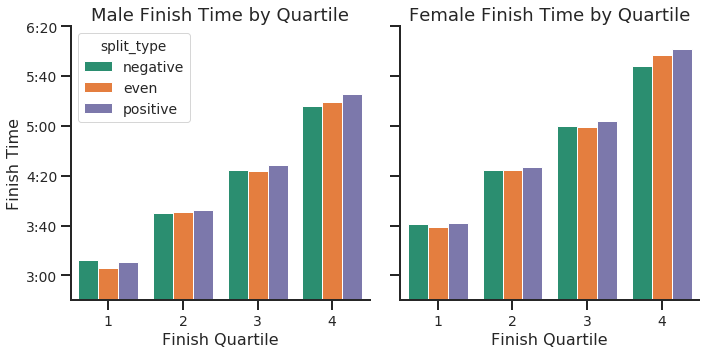

In [37]:
split_type_cat = splits.groupby(['gender', 'quartile', 'split_type'])['split_Finish'].mean()
split_type_cat = split_type_cat.reset_index()
split_type_cat['split_Finish'] = split_type_cat['split_Finish']/60
ax = sns.catplot(data=split_type_cat, x='quartile', y='split_Finish', hue='split_type', 
                 hue_order=['negative', 'even', 'positive'],
                 palette=[a,b,c], 
                 col='gender', 
                 col_order=['M','F'], 
                 kind='bar', legend_out=False)

ax.set(ylim=(160,360))
ax.set(yticks=np.arange(180, 420, 40))
ax.set(yticklabels=['3:00', '3:40', '4:20', '5:00', '5:40', '6:20'])

ax = ax.axes.flatten()
ax[0].set(title='Male Finish Time by Quartile')
ax[1].set(title='Female Finish Time by Quartile')
ax[0].set(ylabel='Finish Time')
ax[1].set(xlabel='Finish Quartile')
ax[0].set(xlabel='Finish Quartile')

plt.savefig('img/split/split_type_quartile.png')

In [38]:
splits

,name,year,gender,elite,category,quartile,place_gender,place_category,cov,split_Half,split_Half2,split_Finish,split_delta,split_perc,split_type,repeat
0,"kipchoge, eliud",2019,M,elite,18-39,1,1,1,1.354827,3697.0,3660.0,7357.0,-37.0,-0.502922,even,1.0
1,"geremew, mosinet",2019,M,elite,18-39,1,2,2,1.494305,3697.0,3678.0,7375.0,-19.0,-0.257627,even,0.0
2,"kipchoge, eliud",2016,M,elite,18-39,1,1,1,1.555764,3684.0,3701.0,7385.0,17.0,0.230196,even,NaN
3,"wasihun, mule",2019,M,elite,18-39,1,3,3,2.319436,3697.0,3699.0,7396.0,2.0,0.027042,even,0.0
4,"biwott, stanley",2016,M,elite,18-39,1,2,2,2.690619,3684.0,3747.0,7431.0,63.0,0.847800,even,NaN
6,"kipsang, wilson",2014,M,elite,18-39,1,1,1,1.817820,3751.0,3718.0,7469.0,-33.0,-0.441826,even,NaN
7,"kipchoge, eliud",2015,M,elite,18-39,1,1,1,1.917765,3740.0,3742.0,7482.0,2.0,0.026731,even,NaN
8,"kipsang, wilson",2015,M,elite,18-39,1,2,2,1.721197,3740.0,3747.0,7487.0,7.0,0.093495,even,NaN
10,"biwott, stanley",2014,M,elite,18-39,1,2,2,1.875221,3751.0,3744.0,7495.0,-7.0,-0.093396,even,NaN
11,"kitata, tola shura",2019,M,elite,18-39,1,4,4,7.594138,3697.0,3804.0,7501.0,107.0,1.426476,positive,1.0


In [39]:
splits_temp = splits.loc[[0, 1000, 2000],:]

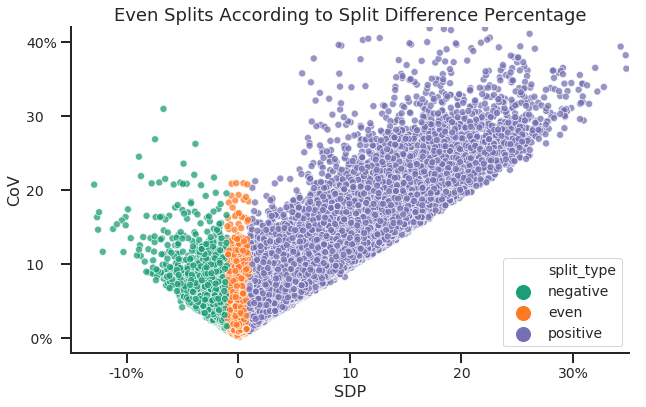

In [40]:
# even splits according to SPD
plt.figure(figsize=(10,6))
sns.scatterplot('split_perc', 'cov', hue='split_type', 
                hue_order=['negative', 'even', 'positive'],
                palette=[a,b,c], alpha=.75, 
                data=splits, s=50)

plt.xlabel('SDP')
plt.ylabel('CoV')

plt.xlim(-15, 35)
plt.xticks(np.arange(-10,40,10), labels=['-10%', '0', '10', '20', '30%'])

plt.ylim(-2, 42)
plt.yticks(np.arange(0,50,10), labels=[' 0% ', '10   ', '20   ', '30   ', '40%'])

plt.title('Even Splits According to Split Difference Percentage')
plt.savefig('img/split/evensdp_scatter.png')
plt.show()

In [41]:
df.groupby(['split_type'])['name'].count()

split_type
even         20068
negative      4199
positive    204228
Name: name, dtype: int64

In [42]:
cov_thresh = 2.3

ratio = df[(df['cov'] < cov_thresh) & (df['split_type']=='even')].shape[0]/df[df['cov'] < cov_thresh].shape[0]
print(ratio)
thresh_n = df[df['cov'] < cov_thresh].shape[0]
print(thresh_n)
print(df.shape[0])
print(thresh_n/df.shape[0])

# renamed df since find and replace is not great w/ notebooks. this df has 2018 filtered out

0.6765832106038292
20370
228495
0.08914855904943216


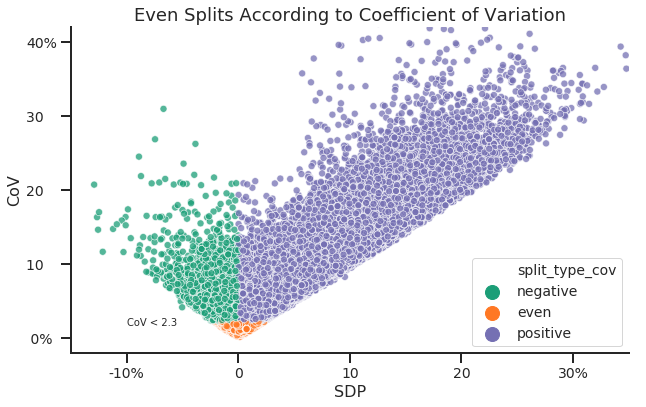

In [43]:
splits['split_type_cov'] = ''
splits.loc[splits['split_delta']<=0, 'split_type_cov'] = 'negative'
splits.loc[splits['split_delta']>0, 'split_type_cov'] = 'positive'
splits.loc[splits['cov'] < cov_thresh, 'split_type_cov'] = 'even'


plt.figure(figsize=(10,6))
sns.scatterplot('split_perc', 'cov', hue='split_type_cov', 
                hue_order=['negative', 'even', 'positive'],
                palette=[a,b,c], 
                alpha=.75, data=splits, s=50)


plt.xlabel('SDP')
plt.ylabel('CoV')

plt.xlim(-15, 35)
plt.xticks(np.arange(-10,40,10), labels=['-10%', '0', '10', '20', '30%'])

plt.ylim(-2, 42)
plt.yticks(np.arange(0,50,10), labels=[' 0% ', '10   ', '20   ', '30   ', '40%'])

plt.annotate('CoV < 2.3', (-10, 1.7))


plt.title('Even Splits According to Coefficient of Variation')
plt.savefig('img/split/evencov_scatter.png')
plt.show()

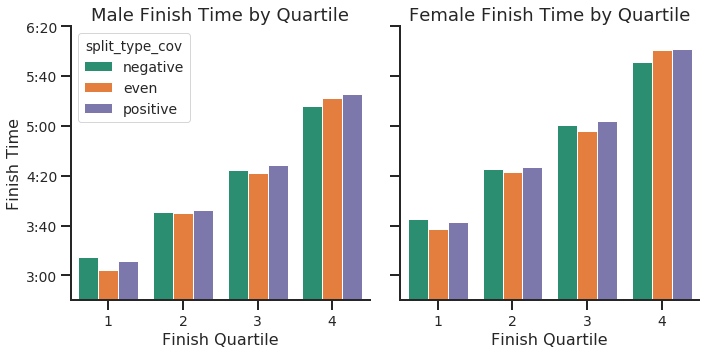

In [44]:
split_type_cat = splits.groupby(['gender', 'quartile', 'split_type_cov'])['split_Finish'].mean()
split_type_cat = split_type_cat.reset_index()
split_type_cat['split_Finish'] = split_type_cat['split_Finish']/60
ax = sns.catplot(data=split_type_cat, x='quartile', y='split_Finish', hue='split_type_cov', 
                 hue_order=['negative', 'even', 'positive'],
                 palette=[a,b,c], 
                 col='gender', 
                 col_order=['M','F'], 
                 kind='bar', legend_out=False)

ax.set(ylim=(160,360))
ax.set(yticks=np.arange(180, 420, 40))
ax.set(yticklabels=['3:00', '3:40', '4:20', '5:00', '5:40', '6:20'])

ax = ax.axes.flatten()
ax[0].set(title='Male Finish Time by Quartile')
ax[1].set(title='Female Finish Time by Quartile')
ax[0].set(ylabel='Finish Time')
ax[1].set(xlabel='Finish Quartile')
ax[0].set(xlabel='Finish Quartile')

plt.savefig('img/split/split_type_cov_quartile.png')

In [45]:
# testing whether even split runners are faster than neg split runners
# use benjamini-hochberg to control fdr. FDR=.05 means that of all rejected hypothesis, roughly 5% of them 
# will be false positives (i.e. incorrectly rejected)
FDR = .05
ntests = 16
res = pd.DataFrame(columns=['method', 'gender', 'quartile', 'pval', 't'])
i=0
for g in ['F', 'M']:
    for q in [1,2,3,4]:
        # testing cov
        temp = splits[(splits['gender']==g) & (splits['quartile']==q)]
        even = temp[temp['split_type_cov']=='even']['split_Finish']
        neg = temp[temp['split_type_cov']=='negative']['split_Finish']
        t, p = stats.ttest_ind(even,neg, equal_var=False)
        #print(g, q, t, p, p/2 < .001)       
        res.loc[i,:] = ['cov', g,q,p/2,t] 
        i+=1
        
        temp = splits[(splits['gender']==g) & (splits['quartile']==q)]
        even = temp[temp['split_type']=='even']['split_Finish']
        neg = temp[temp['split_type']=='negative']['split_Finish']
        t, p = stats.ttest_ind(even,neg, equal_var=False)
        #print(g, q, t, p, p/2 < .001)       
        res.loc[i,:] = ['sdp', g,q,p/2, t] 
        i+=1
        
# under same analysis, even splits are significantly faster than negative
# note that we reject only for t values < 0 (testing even < negative), hence we use p/2 for 1 tail
res = res.sort_values('pval')
res['rank'] = np.arange(0,res.shape[0])+1
res['bh'] = res['rank']*FDR/ntests
res=res.iloc[0:9] # keep tests under a certain criteria
res['signif'] = res['t'] < 0
res[res['signif']==True]


,method,gender,quartile,pval,t,rank,bh,signif
8,cov,M,1,2.39279e-91,-21.7754,1,0.003125,True
9,sdp,M,1,9.09828e-35,-12.594,2,0.006250,True
0,cov,F,1,1.55136e-31,-11.9863,3,0.009375,True
4,cov,F,3,2.16818e-09,-5.93243,4,0.012500,True
2,cov,F,2,1.07284e-08,-5.62956,5,0.015625,True
12,cov,M,3,7.91147e-07,-4.82243,6,0.018750,True
1,sdp,F,1,0.000960731,-3.11141,8,0.025000,True
10,cov,M,2,0.00241135,-2.8212,9,0.028125,True


In [46]:
ag_splits = splits[splits['place_category']<=3].groupby(['gender', 'split_type_cov']).count()
#ag_splits = ag_splits.reset_index()
ag_splits['count'] = ag_splits['name']
ag_splits = ag_splits['count'].reset_index()
ag_splits

,gender,split_type_cov,count
0,F,even,56
1,F,negative,4
2,F,positive,98
3,M,even,58
4,M,negative,2
5,M,positive,103


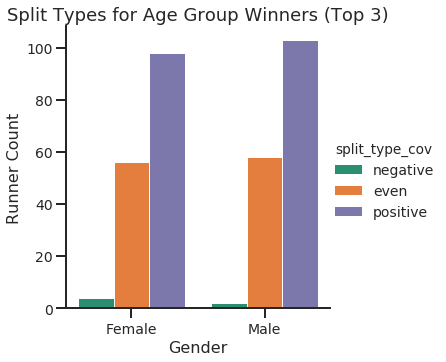

In [47]:
# pacing strategies of top3 age group placers (M/F)
ax = sns.catplot(data=ag_splits, x='gender', y='count', hue='split_type_cov', 
                 hue_order=['negative', 'even', 'positive'],
                 palette=[a,b,c],
                 kind='bar')
ax.set(xticklabels=['Female','Male'])
ax.set(xlabel='Gender')
ax.set(ylabel='Runner Count')
ax.set(title='Split Types for Age Group Winners (Top 3)')

plt.savefig('img/split/split_type_agegroupwinner.png')
plt.plot()

# what about the winners?

winners= splits.groupby(['year', 'gender']).first()
winners = winners.reset_index()
winners.loc[:, ['split_Half', 'split_Half2', 'split_Finish', 'split_delta']] = split_format(winners, names=['split_Half', 'split_Half2', 'split_Finish', 'split_delta'])
winners=winners.loc[:,['year', 'gender', 'name', 'split_Half', 'split_Half2', 'split_Finish', 'split_delta', 'split_type_cov']]

res = ''
for i in np.arange(0,10):
    for j in np.arange(0,8):
        res += '|' + str(winners.iloc[i,j]) 
    res += '|\n'

#print(res)

In [48]:
splits[splits['repeat']==True].groupby(['split_type_cov'])['name'].count() / splits[splits['repeat']==True].shape[0]

split_type_cov
even        0.138196
negative    0.021047
positive    0.840757
Name: name, dtype: float64

In [49]:
splits[splits['repeat']==False].groupby(['split_type_cov'])['name'].count() / splits[splits['repeat']==False].shape[0]

split_type_cov
even        0.091681
negative    0.022179
positive    0.886140
Name: name, dtype: float64

In [50]:
# running the analysis w/ 2018 just for elites

df['split_type_cov'] = ''
df.loc[df['split_delta']<=0, 'split_type_cov'] = 'negative'
df.loc[df['split_delta']>0, 'split_type_cov'] = 'positive'
df.loc[df['cov'] < cov_thresh, 'split_type_cov'] = 'even'

elites = df.groupby(['year', 'gender'])['name', 'split_Half', 'split_Half2', 'split_Finish',
                               'split_delta', 'split_type_cov'].first()
elites = elites.reset_index()
elites


,year,gender,name,split_Half,split_Half2,split_Finish,split_delta,split_type_cov
0,2014,F,"kiplagat, edna",4157.0,4264.0,8421.0,107.0,even
1,2014,M,"kipsang, wilson",3751.0,3718.0,7469.0,-33.0,even
2,2015,F,"tufa, tigist",4303.0,4299.0,8602.0,-4.0,negative
3,2015,M,"kipchoge, eliud",3740.0,3742.0,7482.0,2.0,even
4,2016,F,"sumgong, jemima",4245.0,4333.0,8578.0,88.0,positive
5,2016,M,"kipchoge, eliud",3684.0,3701.0,7385.0,17.0,even
6,2017,F,"keitany, mary",4014.0,4207.0,8221.0,193.0,positive
7,2017,M,"wanjiru, daniel",3703.0,3845.0,7548.0,142.0,positive
8,2018,F,"cheruiyot, vivian",4136.0,4175.0,8311.0,39.0,even
9,2018,M,"kipchoge, eliud",3660.0,3797.0,7457.0,137.0,positive


In [51]:

split_format(elites, names=['split_Half', 'split_Half2', 'split_Finish', 'split_delta'])

,split_Half,split_Half2,split_Finish,split_delta
0,01:09:17,01:11:04,02:20:21,00:01:47
1,01:02:31,01:01:58,02:04:29,-1 days +23:59:27
2,01:11:43,01:11:39,02:23:22,-1 days +23:59:56
3,01:02:20,01:02:22,02:04:42,00:00:02
4,01:10:45,01:12:13,02:22:58,00:01:28
5,01:01:24,01:01:41,02:03:05,00:00:17
6,01:06:54,01:10:07,02:17:01,00:03:13
7,01:01:43,01:04:05,02:05:48,00:02:22
8,01:08:56,01:09:35,02:18:31,00:00:39
9,01:01:00,01:03:17,02:04:17,00:02:17


In [52]:
# TODO: graph relative pace (current split pace / avg pace) by groups, also might be worth investigating % BQ as well 
# if I have extra time
# ok - this is kind of obv. what isn't obv? consistency by age group?
# finish times by age group?
# finish times by people who have >1 marathon in last 5 yrs?

# run a regression model for time projection?


In [53]:
# note that roughly 6k/240k runners had missing split data, so they were dropped
# since we are interested in pace variability, lack of split data = no good
# however we could potentially use them in the future as a test set if we 
# are interested in a time projection model

# con = sqlite3.connect('../nonelite.db')
# df.to_sql(name='complete3',con=con)
# con.close()